# Tee Test

The goal of this notebook is to demonstrate simple hypothesis testing
using both standard and Bayesian methods.

### The Scenario

You are a data scientist for a sporting good manufacturer, Total Tees.
The engineering departments claims that it developed a better golf tee
that can extend the max range of a drive. Although these tees cost
slightly more to produce, the marketing team believes that if they truly
work, the additional sales will make it worth it. But if it turns out that
the tees are the same (or worse), the bad publicity could tank the company.

Your job is to determine whether these tees are truly better, while minimizing
the cost of experimentation. You'll have the opportunity to compare the new
tees with the old tees with the help of some amazing (and expensive) professional
golfers.


# An Initial Study

### Setup
Let's say, for now, that you aren't the one making decisions about how to approach the analysis.
Some senior data scientist tells you how it's going to be done. Here are the details:
- You've hired 30 professional golfers at a rate of $500 an hour.
- Each pro can hit 60 balls per hour.

### Simulation
We are going to create a simulation of the scenario above over a few different cases:
- the new balls are much better than the orginal (5% of max distance increase)
- the new balls are a little better than the original (1% of max distance increase)
- the new balls are the same as the original
- the new balls are slightly worse than the orignal (5% of max distance decrease)

To simlulate the hits of the professional golfer, we need to consider that not every
hit a golfer makes is their best. So, let's operationalize this. Let's say that 
each hit can be placed on a scale of 0 (didn't move the ball) to 1 (direct, perfect hit).
Most of a professional's hits are going to be in the upper range of this scale.
This sounds a lot like a Beta distribution. We'll call it the *goodness-of-hit*.
Let's try one out:


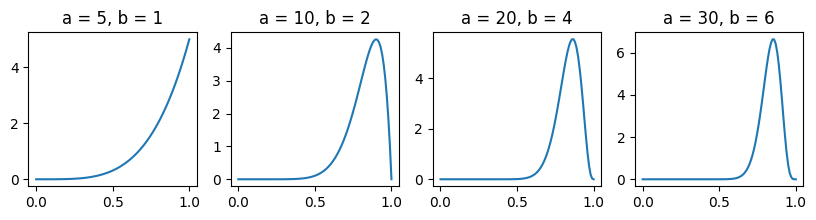

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import beta, norm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(10, 2))

x = np.linspace(0, 1, 100)
a1, b1 = 5, 1
goodness_of_hit1 = beta.pdf(x, a1, b1)
ax[0].plot(x, goodness_of_hit1)
ax[0].set_title(f"a = {a1}, b = {b1}")

a2, b2 = 10, 2
goodness_of_hit2 = beta.pdf(x, a2, b2)
ax[1].plot(x, goodness_of_hit2)
ax[1].set_title(f"a = {a2}, b = {b2}")

a3, b3 = 20, 4
goodness_of_hit3 = beta.pdf(x, a3, b3)
ax[2].plot(x, goodness_of_hit3)
ax[2].set_title(f"a = {a3}, b = {b3}")

a4, b4 = 30, 6
goodness_of_hit4 = beta.pdf(x, a4, b4)
ax[3].plot(x, goodness_of_hit4)
ax[3].set_title(f"a = {a4}, b = {b4}")

plt.show()

Beyond the first plot the peak seems to settle in around 90%.
But as the ratio of the parameters "a" to "b" increase, the steepness of the slope increases.
For this experiment we want a bit of a thicker left tail, because sometimes a hit is just bad.
So, we'll use a = 10, b = 2.

To complete this simulation we'll need a few more elements:
- the golfers are all pro, but they still vary. Some can hit further than others. We will sample from a normal
distribution to simulate random differences between golfers.
- In the real world no two hits are ever the same. Wind resistance, where the ball hits the ground, etc.,
can effect the distance. So, for any given hit we will add some random (normally distributed) noise.

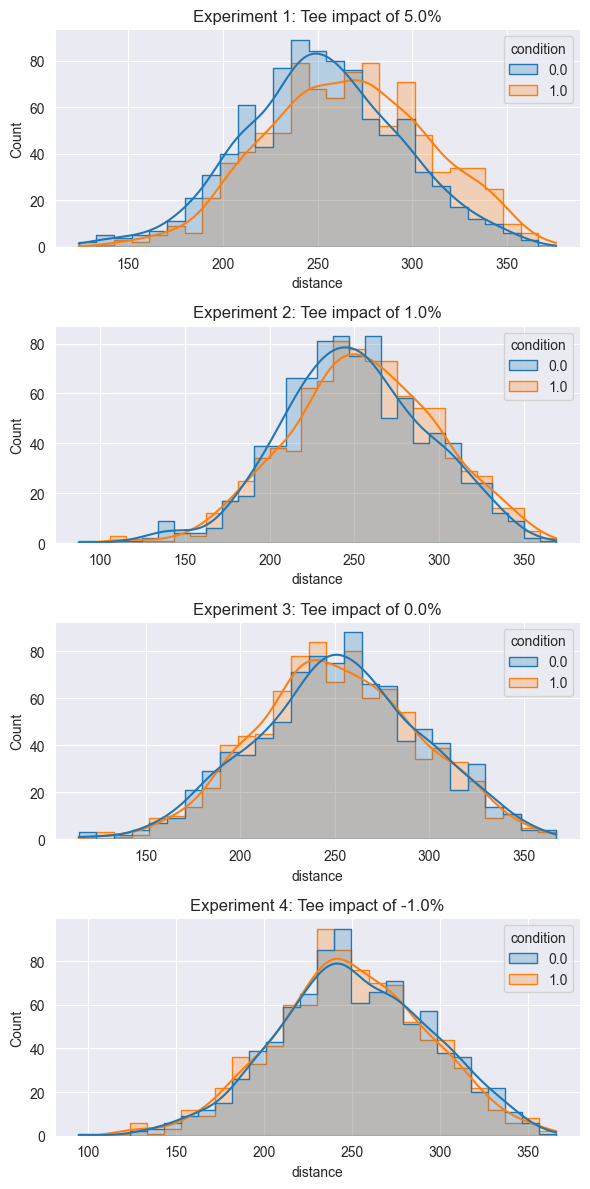

In [44]:
import seaborn as sns
sns.set_style("darkgrid")

# we will run several simulations with different effects
tee_effects = [0.05, 0.01, 0.0, -0.01]

# some experiment parameters
n_golfers = 30
n_hits_per_hour = 60
n_hours = 1
total_hits = n_hits_per_hour * n_hours

# sample the max hit per golfer
max_hit_mean = 300  # yards, kinda making this up
max_hit_sd = 30  # also making this up
max_hit_distances = norm.rvs(loc=max_hit_mean, scale=max_hit_sd, size=n_golfers)
a, b = 10, 2  # beta distribution parameters
noise_sd = 5

# create an array for condition 1 is treatment, 0 is control
condition = np.concatenate(
    (np.ones(total_hits // 2), np.zeros(total_hits - (total_hits // 2)))
)

fig, ax = plt.subplots(len(tee_effects), 1, figsize=(6, len(tee_effects) * 3))
for exp_idx, tee_effect in enumerate(tee_effects):
    results = pd.DataFrame()
    for golfer_idx, max_hit_distance in enumerate(max_hit_distances):
        # randomize condition
        np.random.shuffle(condition)
        # get a set of goodness-of-hit values (0 to 1)
        goodness_of_hit = beta.rvs(a, b, size=total_hits)
        distances = goodness_of_hit * max_hit_distance

        # if treatment group, add the effect
        distances += condition * distances * tee_effect
        # add some noise
        distances += norm.rvs(loc=0, scale=noise_sd, size=len(distances))
        results = pd.concat(
            [
                results,
                pd.DataFrame(
                    {
                        "golfer_idx": [golfer_idx] * total_hits,
                        "experiment": exp_idx,
                        "condition": condition,
                        "distance": distances,
                    }
                ),
            ]
        ).reset_index(drop=True)
    sns.histplot(
        results,
        x="distance",
        stat="count",
        multiple="layer",
        hue="condition",
        kde=True,
        element="step",
        ax=ax[exp_idx],
    )
    ax[exp_idx].set_title(f"Experiment {exp_idx + 1}: Tee impact of {tee_effect * 100}%")
plt.tight_layout()


In [23]:
beta.rvs(a, b, size=60)

array([0.89428694, 0.90990741, 0.97252904, 0.89234146, 0.95381358,
       0.908126  , 0.86702827, 0.7381061 , 0.7398119 , 0.84957533,
       0.88516902, 0.87417338, 0.88529779, 0.8495743 , 0.97390982,
       0.82365053, 0.83801373, 0.68208025, 0.80296818, 0.91325411,
       0.93788901, 0.66838179, 0.86814477, 0.91733745, 0.65075762,
       0.92226997, 0.85454419, 0.99825375, 0.83142199, 0.84754024,
       0.87542426, 0.94398999, 0.87635232, 0.94643854, 0.91662611,
       0.62821472, 0.95126383, 0.90998223, 0.87906482, 0.70052747,
       0.85569943, 0.86272743, 0.95112543, 0.8895389 , 0.8224084 ,
       0.97285252, 0.89875854, 0.77078088, 0.61911566, 0.89301171,
       0.98492972, 0.77261626, 0.93631786, 0.7756395 , 0.82650753,
       0.91570025, 0.691039  , 0.95197356, 0.93155389, 0.95062837])